# Neural Network for Graph Classification: Directed vs Undirected Graphs

**Authors:** Luis Hernandez, Roberto Palacios  
**Note:** This code was partially generated by AI (Grok 3 & Claude 4.0)

## Overview
This project implements a feedforward neural network to classify adjacency matrices as representing either directed or undirected graphs. The neural network learns to distinguish between symmetric (undirected) and non-symmetric (directed) adjacency matrices through supervised learning.

## Key Components
1. **AdjacencyMatrixGenerator**: Generates training data with symmetric/non-symmetric matrices
2. **NeuralNetwork**: Custom feedforward neural network with sigmoid activation and momentum
3. **Profile System**: Pre-configured parameters for different matrix sizes (4x4, 5x5, 6x6)
4. **Comprehensive Analysis**: Learning curves, confusion matrices, and performance metrics

## Architecture
- **Input Layer**: Flattened adjacency matrix (n² features for n×n matrices)
- **Hidden Layer**: Configurable size with sigmoid activation
- **Output Layer**: Single neuron (0 = undirected, 1 = directed)
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Gradient descent with momentum and weight decay

## Features
- Train/validation/test splits with class balance preservation
- Early stopping to prevent overfitting
- Comprehensive learning curve analysis
- Visual confusion matrices and performance metrics
- Hyperparameter sensitivity analysis
- Model capacity analysis
- Profile-based parameter optimization

## Usage
1. Select a profile (4x4, 5x5, or 6x6) by changing `SELECTED_PROFILE`
2. Run the script to train and evaluate the model
3. View comprehensive analysis including learning curves and confusion matrices

## Outputs
- Training progress and final metrics
- Visual learning curves and confusion matrices
- Performance comparison across train/validation/test sets
- Recommendations for hyperparameter tuning

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Tuple
from sklearn.model_selection import train_test_split
import seaborn as sns

# Data Generation Class

This class simulates the generation of training data for graph-based problems, specifically adjacency matrices for directed and undirected graphs. While this is mainly for demonstration (since actual data is loaded from a file), we show how such data could be created from scratch.

1. Create empty lists to store graph adjancey matrices and labels (0 for undirected, 1 for directed).
2. Generation Undirected graphs (symmetric adjacency matrix)
3. Generation of Directed graphs (asymmetric adjacency matrix)
4. Generation of dataset, accepts desired matrix size and num of each graph type, stores matrices and labels.
5. Packs generated matrices, labels, and matrix size into a dictionary, then serializes and writes to a pickel file.
6. Loads from pickled file, restores matrices and labels into the object.
7. Flattens data for neural network input - convers each matrix into a flat vector (1D array), returns them along with corresponding labels as NumPy arrays.

In [100]:
# ===============================================
# DATA GENERATION CLASS
# ===============================================
# This class shows how our training data was generated.
# The actual data used in this experiment is loaded from a pickle file below.

class AdjacencyMatrixGenerator:
    """
    A class to generate adjacency matrices for directed and undirected graphs.
    This code is included for transparency - actual data is loaded from pickle file.
    """

    def __init__(self):
        # Initialize empty lists to store generated matrices and their corresponding labels
        self.matrices = []
        self.labels = []

    def generate_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a symmetric adjacency matrix (undirected graph)."""
        # Create a random binary matrix of shape (n, n)
        matrix = np.random.randint(0, 2, size=(n, n))

        # Use the upper triangle and mirror it to the lower triangle to ensure symmetry
        matrix = np.triu(matrix) + np.triu(matrix, 1).T

        # Remove self-loops by setting the diagonal to 0
        np.fill_diagonal(matrix, 0)

        # Return the symmetric matrix (undirected graph representation)
        return matrix

    def generate_non_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a non-symmetric adjacency matrix (directed graph)."""
        # Generate a random binary matrix of shape (n, n)
        matrix = np.random.randint(0, 2, size=(n, n))

        # Remove self-loops by setting diagonal elements to 0
        np.fill_diagonal(matrix, 0)

        # Check if matrix accidentally ended up symmetric
        if np.array_equal(matrix, matrix.T):
            # Try to break symmetry by flipping a single edge
            for i in range(n):
                for j in range(i+1, n):
                    # Look for a pair of symmetric values
                    if matrix[i, j] == matrix[j, i]:
                        # Flip one of them to break symmetry
                        matrix[i, j] = 1 - matrix[i, j]
                        break
                else:
                    # Continue outer loop if inner did not break
                    continue
                # Break outer loop if inner broke (symmetry broken)
                break

        # Return the asymmetric matrix (directed graph representation)
        return matrix

    def generate_dataset(self, n: int, num_symmetric: int, num_non_symmetric: int):
        """Generate a dataset of adjacency matrices."""
        # Clear previous data if any
        self.matrices = []
        self.labels = []

        # Generate symmetric (undirected) matrices and label them as 0
        for _ in range(num_symmetric):
            matrix = self.generate_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(0)

        # Generate non-symmetric (directed) matrices and label them as 1
        for _ in range(num_non_symmetric):
            matrix = self.generate_non_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(1)

    def save_to_pickle(self, filename: str):
        """Save the generated matrices and labels to a pickle file."""
        # Package data into a dictionary for saving
        data = {
            'matrices': self.matrices,  # list of adjacency matrices
            'labels': self.labels,      # corresponding labels (0 or 1)
            'matrix_size': len(self.matrices[0]) if self.matrices else 0  # size of each matrix
        }

        # Write the data to a binary file using pickle
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

        # Log confirmation of save
        print(f"Saved {len(self.matrices)} matrices to {filename}")

    def load_from_pickle(self, filename: str):
        """Load matrices and labels from a pickle file."""
        # Open and load the binary pickle file
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        # Restore matrices and labels to internal state
        self.matrices = data['matrices']
        self.labels = data['labels']

        # Log confirmation of load
        print(f"Loaded {len(self.matrices)} matrices from {filename}")

    def get_flattened_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Get matrices flattened into vectors for neural network input."""
        # If no matrices exist, return empty arrays
        if not self.matrices:
            return np.array([]), np.array([])

        # Flatten each 2D matrix into a 1D vector
        flattened_matrices = np.array([matrix.flatten() for matrix in self.matrices])

        # Convert labels list into a NumPy array
        labels_array = np.array(self.labels)

        # Return (X, y) where X = feature vectors, y = labels
        return flattened_matrices, labels_array

# Neural Network class

1. Initialization: the neural network is set up with 1 hidden layer, using He initialization for stable learning and momentum terms to smooth weight updates.
2. Forward Pass: Input data flows through the network using sigmoid activation to compute the output predictions.
3. Backward Pass (Backpropagation): The network calculates prediction errors, computes gradients using the sigmoid derivative, updates weights using momentum, and applies weight decay to prevent overfitting.
4. Training Loop: The model iteratively trains across epochs while tracking training and validation errors, using early stopping if validation performance plateaus too long.
5. Plotting Learning Curves: A visualization function graphs error curves for training and validation to monitor learning progress, diagnose overfitting, and identify the ideal stopping point.



In [101]:
# Neural Network class to classify graphs
class NeuralNetwork:
    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function to map values to (0, 1)"""
        # Compress input into a range between 0 and 1
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_derivative_from_output(x):
        """Derivative of sigmoid for backpropagation"""
        # Efficient derivative formula when sigmoid output already available
        return x * (1 - x)

    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for better initial performance
        # Helps avoid vanishing/exploding gradients in deep nets
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))  # bias for hidden layer
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))  # bias for output layer

        # Add momentum for smoother training
        # Momentum helps accelerate SGD and avoid oscillation
        self.momentum = 0.9
        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)

    def forward(self, X):
        # First layer linear combination + activation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Second layer (output) linear combination + activation
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        return self.a2  # output of the network

    def backward(self, X, y, output, learning_rate, weight_decay):
        # Compute error at output layer
        self.error = y - output

        # Backpropagation: delta for output layer
        self.delta2 = self.error * self.sigmoid_derivative_from_output(output)

        # Backpropagate error to hidden layer
        self.error_hidden = np.dot(self.delta2, self.W2.T)
        self.delta1 = self.error_hidden * self.sigmoid_derivative_from_output(self.a1)

        # More efficient momentum updates
        # Apply gradients and weight decay, scaled by momentum
        self.v_W2 = self.momentum * self.v_W2 + learning_rate * (np.dot(self.a1.T, self.delta2) - weight_decay * self.W2)
        self.v_b2 = self.momentum * self.v_b2 + learning_rate * np.sum(self.delta2, axis=0, keepdims=True)
        self.v_W1 = self.momentum * self.v_W1 + learning_rate * (np.dot(X.T, self.delta1) - weight_decay * self.W1)
        self.v_b1 = self.momentum * self.v_b1 + learning_rate * np.sum(self.delta1, axis=0, keepdims=True)

        # Update weights using accumulated momentum deltas
        self.W2 += self.v_W2
        self.b2 += self.v_b2
        self.W1 += self.v_W1
        self.b1 += self.v_b1

    def train(self, X, y, X_val, y_val, epochs, learning_rate, weight_decay, patience=1000):
        errors = []      # List to store training errors
        val_errors = []  # List to store validation errors
        best_error = float('inf')  # Track best validation error for early stopping
        patience_counter = 0       # Counter to stop if no improvement

        # Training meta info
        print(f"Training: {epochs} epochs max, LR: {learning_rate}, WD: {weight_decay}")
        print("Epoch | Train MSE | Val MSE | Gap | Status")
        print("-" * 45)

        for epoch in range(epochs):
            # Forward and backward pass
            output = self.forward(X)
            self.backward(X, y, output, learning_rate, weight_decay)

            # Compute MSE (Mean Squared Error) for training
            mse = np.mean(np.square(y - output))
            errors.append(mse)

            # Compute validation MSE
            val_output = self.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            val_errors.append(val_mse)

            # Early stopping logic (stop if no improvement)
            if val_mse < best_error:
                best_error = val_mse
                patience_counter = 0
                status = "↘️"  # validation improving
            else:
                patience_counter += 1
                status = "→"  # no improvement

            # Stop early if patience exhausted
            if patience_counter >= patience:
                print(f"{epoch:5d} | {mse:.6f} | {val_mse:.6f} | {val_mse-mse:.6f} | Early Stop!")
                break

            # Periodic training feedback
            if epoch % 1000 == 0:
                gap = val_mse - mse
                print(f"{epoch:5d} | {mse:.6f} | {val_mse:.6f} | {gap:.6f} | {status}")

        # Final result
        print(f"Final - Train MSE: {errors[-1]:.6f}, Val MSE: {val_errors[-1]:.6f}")
        return errors, val_errors

# Accuracy and learning curves, learning rate sensitivy and model capacity analysis.

1. Accuracy Visualization: Plots training and validation accuracy over epochs to monitor learning quality and detect overfitting.

2. Error Visualization: Displays the raw training and validation error (log-scaled), while overlaying the accuracy gap to signal overfitting trends.

3. Learning Rate Sensitivity: Tests different learning rates around the current one to see how training stability and performance are affected.

4. Model Capacity Analysis: Evaluates how the size of the hidden layer influences training/validation errors to diagnose underfitting or overfitting.

In [102]:
def plot_comprehensive_learning_curves(train_errors, val_errors, nn, X_train, y_train, X_val, y_val,
                                      learning_rates=[0.001, 0.01, 0.1, 0.5],
                                      hidden_sizes=None, save_path=None):
    """Plot comprehensive learning curves showing all aspects of training."""

    # Create 2x2 grid of subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Learning Curve Analysis', fontsize=16, fontweight='bold')

    epochs = range(len(train_errors))  # Epoch index list

    # ===============================================
    # 1. ACCURACY CURVES (Top Left)
    # ===============================================

    # Convert error to accuracy as (1 - relative error)
    max_error = max(max(train_errors), max(val_errors))
    train_accuracies = [(max_error - err) / max_error for err in train_errors]
    val_accuracies = [(max_error - err) / max_error for err in val_errors]

    # Plot training and validation accuracy
    ax1.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('1. Training vs Validation Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)  # Accuracy ranges from 0 to 1

    # Highlight where overfitting likely starts by detecting diverging accuracy trends
    if len(train_accuracies) > 1000:
        val_decreasing = False
        overfitting_start = None
        for i in range(1000, len(val_accuracies)-1):
            if val_accuracies[i] < val_accuracies[i-1] and train_accuracies[i] > train_accuracies[i-1]:
                if not val_decreasing:
                    overfitting_start = i
                    val_decreasing = True
            elif val_accuracies[i] > val_accuracies[i-1]:
                val_decreasing = False

        # Mark the epoch where overfitting begins
        if overfitting_start:
            ax1.axvline(x=overfitting_start, color='orange', linestyle='--',
                       alpha=0.7, label=f'Overfitting starts ~epoch {overfitting_start}')
            ax1.legend()

    # ===============================================
    # 2. ERROR CURVES (Top Right)
    # ===============================================

    # Plot raw MSE errors on a logarithmic scale
    ax2.plot(epochs, train_errors, 'b-', label='Training Error', linewidth=2, alpha=0.8)
    ax2.plot(epochs, val_errors, 'r-', label='Validation Error', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title('2. Training vs Validation Error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')  # Log scale helps visualize small differences

    # Plot the gap between training and validation accuracy
    gaps = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, gaps, 'g--', label='Accuracy Gap', linewidth=1, alpha=0.6)
    ax2_twin.set_ylabel('Accuracy Gap', color='g')
    ax2_twin.tick_params(axis='y', labelcolor='g')
    ax2_twin.axhline(y=0.05, color='orange', linestyle=':', alpha=0.7, label='Overfitting threshold')
    ax2_twin.legend(loc='upper right')

    # ===============================================
    # 3. LEARNING RATE SENSITIVITY (Bottom Left)
    # ===============================================

    lr_results = []

    # Save current network weights to reset during testing
    current_weights = {
        'W1': nn.W1.copy(), 'W2': nn.W2.copy(),
        'b1': nn.b1.copy(), 'b2': nn.b2.copy()
    }

    # Use a logarithmic sweep of learning rates around current one
    current_lr = learning_rate  # <-- This variable must exist outside this function
    learning_rates = [
        current_lr * 0.1, current_lr * 0.5,
        current_lr, current_lr * 2,
        current_lr * 5, current_lr * 10
    ]

    for lr in learning_rates:
        # Restore original weights for fair comparison
        nn.W1 = current_weights['W1'].copy()
        nn.W2 = current_weights['W2'].copy()
        nn.b1 = current_weights['b1'].copy()
        nn.b2 = current_weights['b2'].copy()

        test_errors = []
        val_errors_lr = []

        # Short training loop to observe immediate impact of learning rate
        for epoch in range(100):
            output = nn.forward(X_train)
            nn.backward(X_train, y_train, output, lr, weight_decay)
            mse = np.mean(np.square(y_train - output))
            test_errors.append(mse)

            val_output = nn.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            val_errors_lr.append(val_mse)

        lr_results.append((lr, val_errors_lr[-1], test_errors[-1]))  # Track final errors

    # Unpack results into lists
    lrs, final_val_errors, final_train_errors = zip(*lr_results)

    # Plot how validation error changes with learning rate
    ax3.semilogx(lrs, final_val_errors, 'bo-', linewidth=2, markersize=8, label='Validation Error')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Final Validation Error')
    ax3.set_title('3. Learning Rate Sensitivity')
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=current_lr, color='red', linestyle='--', alpha=0.7,
               label=f'Current LR: {current_lr}')
    ax3.legend()

    # ===============================================
    # 4. MODEL CAPACITY ANALYSIS (Bottom Right)
    # ===============================================

    capacity_results = []

    original_hidden_size = nn.W1.shape[0]
    actual_input_size = X_train.shape[1]
    current_size = original_hidden_size  # Save current hidden layer size

    # If no custom hidden sizes, define a range around current size
    if hidden_sizes is None:
        hidden_sizes = [
            max(2, current_size // 4),
            max(4, current_size // 2),
            current_size,
            current_size * 2,
            current_size * 4,
            current_size * 8
        ]

    if current_size not in hidden_sizes:
        hidden_sizes.append(current_size)
    hidden_sizes = sorted(list(set(hidden_sizes)))  # Sort and deduplicate

    print(f"Testing capacity sizes: {hidden_sizes}")

    for hidden_size in hidden_sizes:
        # Instantiate a new model with this capacity
        temp_nn = NeuralNetwork(input_size=actual_input_size, hidden_size=hidden_size, output_size=1)

        temp_train_errors = []
        temp_val_errors = []

        # Train longer to fully evaluate capacity impact
        for epoch in range(300):
            output = temp_nn.forward(X_train)
            temp_nn.backward(X_train, y_train, output, learning_rate, weight_decay)
            train_mse = np.mean(np.square(y_train - output))
            temp_train_errors.append(train_mse)

            val_output = temp_nn.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            temp_val_errors.append(val_mse)

        # Store final errors
        capacity_results.append((hidden_size, temp_val_errors[-1], temp_train_errors[-1]))

    hidden_sizes_list, final_val_errors_cap, final_train_errors_cap = zip(*capacity_results)

    # Plot training/validation error vs. hidden layer size
    ax4.plot(hidden_sizes_list, final_val_errors_cap, 'go-', linewidth=2, markersize=8, label='Validation Error')
    ax4.plot(hidden_sizes_list, final_train_errors_cap, 'bo-', linewidth=2, markersize=6, alpha=0.7, label='Training Error')
    ax4.set_xlabel('Hidden Layer Size')
    ax4.set_ylabel('Final Error')
    ax4.set_title('4. Model Capacity Analysis')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # Emphasize the current hidden size
    current_idx = hidden_sizes_list.index(current_size) if current_size in hidden_sizes_list else None
    if current_idx is not None:
        ax4.plot(current_size, final_val_errors_cap[current_idx], 'ro', markersize=12,
                 markeredgecolor='black', markeredgewidth=2, label=f'Current Size: {current_size}')
    ax4.axvline(x=current_size, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax4.legend()

    ax4.set_xlim(min(hidden_sizes_list) * 0.8, max(hidden_sizes_list) * 1.2)  # Reasonable display range

    plt.tight_layout()

    # Save plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

        # ===============================================
    # COMPREHENSIVE ANALYSIS
    # ===============================================
    print("\n" + "="*60)
    print("COMPREHENSIVE LEARNING CURVE ANALYSIS")
    print("="*60)

    # 1. Accuracy Analysis
    final_acc_gap = train_accuracies[-1] - val_accuracies[-1]
    print(f"\n1. ACCURACY ANALYSIS:")
    print(f"   Final Training Accuracy: {train_accuracies[-1]:.2%}")
    print(f"   Final Validation Accuracy: {val_accuracies[-1]:.2%}")
    print(f"   Accuracy Gap: {final_acc_gap:.2%}")

    if final_acc_gap > 0.05:
        print("   ⚠️  Significant overfitting detected")
    elif final_acc_gap < 0.01:
        print("   ✅ Good generalization")
    else:
        print("   ⚠️  Moderate overfitting")

    # 2. Error Analysis
    final_error_gap = val_errors[-1] - train_errors[-1]
    print(f"\n2. ERROR ANALYSIS:")
    print(f"   Final Training Error: {train_errors[-1]:.6f}")
    print(f"   Final Validation Error: {val_errors[-1]:.6f}")
    print(f"   Error Gap: {final_error_gap:.6f}")

    # 3. Learning Rate Analysis
    best_lr_idx = np.argmin(final_val_errors)
    best_lr = lrs[best_lr_idx]
    current_lr_performance = final_val_errors[lrs.index(current_lr)]
    best_lr_performance = final_val_errors[best_lr_idx]

    print(f"\n3. LEARNING RATE ANALYSIS:")
    print(f"   Best Learning Rate: {best_lr}")
    print(f"   Current Learning Rate: {current_lr}")
    print(f"   Current LR Performance: {current_lr_performance:.6f}")
    print(f"   Best LR Performance: {best_lr_performance:.6f}")

    # Only recommend if there's significant improvement and LR is reasonable
    improvement = (current_lr_performance - best_lr_performance) / current_lr_performance
    lr_ratio = best_lr / current_lr

    if improvement > 0.1 and 0.1 <= lr_ratio <= 10:  # 10% improvement and reasonable ratio
        print(f"   💡 Consider adjusting learning rate to {best_lr}")
    else:
        print(f"   ✅ Learning rate appears optimal")
        if improvement <= 0.1:
            print(f"   (Improvement too small: {improvement:.1%})")
        if lr_ratio < 0.1 or lr_ratio > 10:
            print(f"   (Suggested LR too extreme: {lr_ratio:.1f}x current)")

    # 4. Capacity Analysis
    best_capacity_idx = np.argmin(final_val_errors_cap)
    best_capacity = hidden_sizes_list[best_capacity_idx]
    print(f"\n4. CAPACITY ANALYSIS:")
    print(f"   Best Hidden Size: {best_capacity}")
    print(f"   Current Hidden Size: {current_size}")
    if best_capacity != current_size:
        print(f"   💡 Consider adjusting hidden layer size to {best_capacity}")
    else:
        print(f"   ✅ Hidden layer size appears optimal")

    # 5. Overall Recommendations
    print(f"\n5. OVERALL RECOMMENDATIONS:")
    recommendations = []

    if final_acc_gap > 0.05:
        recommendations.append("Reduce model complexity or increase regularization")
    if improvement > 0.1 and 0.1 <= lr_ratio <= 10:
        recommendations.append(f"Adjust learning rate to {best_lr}")
    if best_capacity != current_size:
        recommendations.append(f"Consider hidden layer size of {best_capacity}")
    if len(recommendations) == 0:
        recommendations.append("Model appears well-tuned!")

    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")

    print("="*60)

    return {
        'best_lr': best_lr,
        'best_capacity': best_capacity,
        'overfitting_gap': final_acc_gap,
        'recommendations': recommendations
    }


# Profile system for different matrix sizes

1. Define multiple training profiles optimized for different matrix sizes (4×4, 5×5, 6×6).
2. Each profile includes training hyperparameters like hidden layer size, learning rate, regularization, and data file name.
3. A helper function shows the available profiles and whether their corresponding training data files exist.
4. You choose which profile to use by setting the SELECTED_PROFILE variable.
5. The selected profile's parameters are loaded into global variables for use in training.
6. The profile's parameters (like matrix size, hidden size, and learning rate) are printed to confirm the setup.

In [103]:
# ===============================================
# PROFILE SYSTEM FOR DIFFERENT MATRIX SIZES
# ===============================================
# Choose your profile by setting the profile name
# Each profile has optimized parameters for its matrix size

PROFILES = {
    "4x4": {
        "matrix_size": 4,                # Size of square matrix (4x4 = 16 features)
        "hidden_size": 8,                # Neural net hidden layer size (small for efficiency)
        "learning_rate": 0.0005,         # Low LR to prevent unstable updates
        "weight_decay": 0.02,            # Higher regularization to avoid overfitting
        "epochs": 10000,                 # Number of training epochs
        "num_samples": 6000,             # Number of samples in training dataset
        "data_file": "neural_network_training_data_4x4.pkl",  # Filename for training data
        "description": "Small matrices"  # User-friendly description
    },
    "5x5": {
        "matrix_size": 5,
        "hidden_size": 6,                # Slightly larger hidden layer than 4x4
        "learning_rate": 0.001,          # Standard LR, no dynamic scheduling
        "weight_decay": 0.02,            # Balanced regularization
        "epochs": 15000,                 # Slightly more training steps (but will use early stopping)
        "num_samples": 8000,
        "data_file": "neural_network_training_data_5x5.pkl",
        "description": "Medium matrices"
    },
    "6x6": {
        "matrix_size": 6,
        "hidden_size": 36,               # Much larger hidden layer to model bigger matrices
        "learning_rate": 0.001,          # More stable training due to larger model
        "weight_decay": 0.01,            # Standard regularization
        "epochs": 7000,                  # Fewer epochs due to complexity and overfitting risk
        "num_samples": 8000,
        "data_file": "neural_network_training_data_6x6.pkl",
        "description": "Large matrices"
    }
}

def show_available_profiles():
    """Display all available profiles and their status"""
    print("📋 Available Profiles:")
    print("=" * 60)
    for name, config in PROFILES.items():
        import os
        data_exists = os.path.exists(config["data_file"])  # Check if dataset file exists
        status = "✅ Data ready" if data_exists else "❌ No data"  # Print status based on file presence

        # Display all profile parameters in a readable format
        print(f"🎯 {name}: {config['description']}")
        print(f"   📊 {config['matrix_size']}x{config['matrix_size']} matrices")
        print(f"   🧠 Hidden size: {config['hidden_size']}")
        print(f"   📈 LR: {config['learning_rate']}, WD: {config['weight_decay']}")
        print(f"   🔄 Epochs: {config['epochs']}, Samples: {config['num_samples']}")
        print(f"   💾 {config['data_file']} - {status}")
        print()

# Uncomment the line below to see all available profiles with their statuses
# show_available_profiles()

# ===============================================
# SELECT YOUR PROFILE HERE
# ===============================================
# Change this line to switch between profiles
SELECTED_PROFILE = "6x6"  # Options: "4x4", "5x5", "6x6"

# Load the selected profile from the dictionary
if SELECTED_PROFILE not in PROFILES:
    print(f"❌ Profile '{SELECTED_PROFILE}' not found. Available profiles: {list(PROFILES.keys())}")
    exit(1)

# Extract profile-specific parameters into variables for convenience
profile = PROFILES[SELECTED_PROFILE]
matrix_size = profile["matrix_size"]
hidden_size = profile["hidden_size"]
learning_rate = profile["learning_rate"]
weight_decay = profile["weight_decay"]
epochs = profile["epochs"]
num_samples = profile["num_samples"]
data_file = profile["data_file"]

# Compute input size based on matrix dimensions (flattened square matrix)
input_size = matrix_size * matrix_size
output_size = 1  # Assuming scalar output prediction

# Print a summary of the selected profile for confirmation
print(f"🎯 Using Profile: {SELECTED_PROFILE}")
print(f"📊 Matrix size: {matrix_size}x{matrix_size} ({input_size} features)")
print(f"🧠 Hidden layer size: {hidden_size}")
print(f"📈 Learning rate: {learning_rate}")
print(f"⚖️  Weight decay: {weight_decay}")
print(f"🔄 Epochs: {epochs}")
print(f"📦 Samples: {num_samples}")
print(f"💾 Data file: {data_file}")
print("-" * 50)


🎯 Using Profile: 6x6
📊 Matrix size: 6x6 (36 features)
🧠 Hidden layer size: 36
📈 Learning rate: 0.001
⚖️  Weight decay: 0.01
🔄 Epochs: 7000
📦 Samples: 8000
💾 Data file: neural_network_training_data_6x6.pkl
--------------------------------------------------


# Loading data

1. Create an instance of the AdjacencyMatrixGenerator to handle data.2. Try to load training data from a .pkl file (a saved, reusable dataset).
3. If the file is found: Make sure the matrix size in the file matches the expected profile. If not, regenerate the dataset with the correct size and overwrite the old file.
4. If the file is missing: Generate a new dataset from scratch and save it as a pickle file.
5. Extract flattened matrix features X and their labels y, reshaping them to be ready for neural network input.

In [104]:
# ===============================================
# LOAD TRAINING DATA
# ===============================================
# Load data using our class methods
generator = AdjacencyMatrixGenerator()

# Option 1: Load from pickle file (recommended for reproducibility)
try:
    generator.load_from_pickle(data_file)
    print("Using pre-generated dataset for reproducible results")

    # Check if the loaded data matches our expected matrix size
    if generator.matrices and len(generator.matrices[0]) != matrix_size:
        print(f"⚠️  Loaded data has {len(generator.matrices[0])}x{len(generator.matrices[0])} matrices, but expected {matrix_size}x{matrix_size}")
        print("Regenerating dataset with correct matrix size...")
        generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
        generator.save_to_pickle(data_file)
        print(f"✅ Generated new {matrix_size}x{matrix_size} dataset")

except FileNotFoundError:
    print("Pickle file not found. Generating new dataset...")
    generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
    generator.save_to_pickle(data_file)

# Get data ready for neural network
X, y = generator.get_flattened_data()
y = y.reshape(-1, 1)  # Reshape for neural network compatibility

print(f"Dataset ready: {len(X)} samples, {X.shape[1]} features each")

Loaded 8000 matrices from neural_network_training_data_6x6.pkl
Using pre-generated dataset for reproducible results
Dataset ready: 8000 samples, 36 features each


# Training/validation/test split

1. Split the entire dataset into 80% temporary set (train+val) and 20% test set, keeping class distribution balanced.
2. Further split the temporary set into 60% training and 20% validation subsets (relative to the original data size), maintaining stratification.
3. Print out the number of samples in each of the train, validation, and test sets.
4. Count and print how many samples belong to each class (undirected=0, directed=1) in each dataset split to verify class balance.

In [105]:
# ===============================================
# TRAIN/VALIDATION/TEST SPLIT
# ===============================================

from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training+validation (80%) and test (20%) sets
# stratify=y ensures class distribution is preserved in each split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split the temporary set (X_temp, y_temp) into:
# - Training set: 60% of total data
# - Validation set: 20% of total data
# Here test_size=0.25 means 25% of 80% (which equals 20% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Print the size of each split to verify
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Check class balance in each split by counting zeros and ones
train_zeros = np.sum(y_train == 0)  # Undirected class count in training
train_ones = np.sum(y_train == 1)   # Directed class count in training
val_zeros = np.sum(y_val == 0)      # Undirected class count in validation
val_ones = np.sum(y_val == 1)       # Directed class count in validation
test_zeros = np.sum(y_test == 0)    # Undirected class count in test
test_ones = np.sum(y_test == 1)     # Directed class count in test

# Print class distribution for each dataset split
print(f"Training - Undirected: {train_zeros}, Directed: {train_ones}")
print(f"Validation - Undirected: {val_zeros}, Directed: {val_ones}")
print(f"Test - Undirected: {test_zeros}, Directed: {test_ones}")


Training set: 4800 samples
Validation set: 1600 samples
Test set: 1600 samples
Training - Undirected: 2400, Directed: 2400
Validation - Undirected: 800, Directed: 800
Test - Undirected: 800, Directed: 800


# Metrics functions

1. Convert predicted probabilities into binary predictions based on a threshold and calculate accuracy and confusion matrix components (TP, TN, FP, FN).
2. Compute precision, recall, F1 score, and mean squared error (MSE) for classification quality assessment.
3. Return all these calculated metrics as a dictionary.
4. Plot a nicely formatted confusion matrix heatmap with annotation and display performance metrics on the plot.
5. Optionally save the confusion matrix figure to a file if a save path is provided.
6. Print the confusion matrix as a neatly formatted text table.
7. Print all detailed metrics (accuracy, precision, recall, F1, MSE) in a readable text format.

In [106]:
# ===============================================
# IMPROVED METRICS FUNCTIONS
# ===============================================

def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate comprehensive classification metrics."""
    # Convert probabilities into binary class predictions (0 or 1) using threshold
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate overall accuracy: percentage of correct predictions
    accuracy = np.mean(y_pred == y_true)

    # Calculate confusion matrix components:
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False negatives

    # Calculate precision, recall, and F1 score with safety checks for zero division
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate mean squared error between predicted probabilities and true labels
    mse = np.mean(np.square(y_pred_proba - y_true))

    # Return all metrics in a dictionary for easy access
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mse': mse,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }


def plot_confusion_matrix(metrics, dataset_name="", save_path=None):
    """Create a visual confusion matrix plot."""
    # Extract confusion matrix values from metrics dictionary
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']

    # Construct confusion matrix array for heatmap plotting
    cm = np.array([[tn, fp], [fn, tp]])

    # Create matplotlib figure and axis for plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap of confusion matrix with annotations and labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Undirected', 'Predicted Directed'],
                yticklabels=['Actual Undirected', 'Actual Directed'],
                ax=ax, cbar_kws={'label': 'Count'})

    # Add title and axis labels with styling
    ax.set_title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)

    # Prepare performance metric text to display on plot
    accuracy = metrics['accuracy']
    precision = metrics['precision']
    recall = metrics['recall']
    f1_score = metrics['f1_score']

    textstr = f'Accuracy: {accuracy:.2%}\nPrecision: {precision:.2%}\nRecall: {recall:.2%}\nF1-Score: {f1_score:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

    # Place the metrics text box in the bottom right corner of the plot
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

    plt.tight_layout()

    # Save the plot to a file if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the confusion matrix plot
    plt.show()

    # Return the figure object for further manipulation if needed
    return fig


def print_confusion_matrix(metrics, dataset_name=""):
    """Print a formatted confusion matrix."""
    print(f"\n=== {dataset_name.upper()} CONFUSION MATRIX ===")
    print(f"                Predicted")
    print(f"Actual  Undirected  Directed")
    print(f"Undirected    {metrics['tn']:4d}      {metrics['fp']:4d}")
    print(f"Directed      {metrics['fn']:4d}      {metrics['tp']:4d}")
    print(f"Total: {metrics['tn'] + metrics['fp'] + metrics['fn'] + metrics['tp']}")


def print_detailed_metrics(metrics, dataset_name=""):
    """Print comprehensive metrics."""
    print(f"\n=== {dataset_name.upper()} METRICS ===")
    print(f"Accuracy:  {metrics['accuracy']:.2%}")
    print(f"Precision: {metrics['precision']:.2%}")
    print(f"Recall:    {metrics['recall']:.2%}")
    print(f"F1-Score:  {metrics['f1_score']:.2%}")
    print(f"MSE:       {metrics['mse']:.6f}")


# Efficient training with validation monitoring

1. Create the neural network using the specified input size, hidden layer size, and output size.
2. Start the training process using both training and validation sets while monitoring validation performance to stop early if needed.

In [107]:
# ===============================================
# EFFICIENT TRAINING WITH VALIDATION MONITORING
# ===============================================
# Initialize the neural network with specified architecture
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the network with validation monitoring
print("Starting efficient training with validation monitoring...")
train_errors, val_errors = nn.train(X_train, y_train, X_val, y_val, epochs, learning_rate, weight_decay, patience=1000)

Starting efficient training with validation monitoring...
Training: 7000 epochs max, LR: 0.001, WD: 0.01
Epoch | Train MSE | Val MSE | Gap | Status
---------------------------------------------
    0 | 0.252561 | 0.251803 | -0.000758 | ↘️
 1000 | 0.000478 | 0.003039 | 0.002561 | ↘️
 2000 | 0.000312 | 0.002604 | 0.002293 | ↘️
 3000 | 0.000280 | 0.002462 | 0.002182 | ↘️
 4000 | 0.000269 | 0.002379 | 0.002110 | ↘️
 5000 | 0.000264 | 0.002318 | 0.002054 | ↘️
 6000 | 0.000259 | 0.002270 | 0.002011 | ↘️
Final - Train MSE: 0.000255, Val MSE: 0.002231


# Validation evaluation

1. Loop over each sample in the validation set, run it through the neural network to get a prediction, and collect all predictions.
2. Convert the collected predictions into a NumPy array for further processing.
3. Calculate classification metrics comparing true labels to predictions.
4. Print out detailed validation metrics.

In [108]:
# ===============================================
# VALIDATION EVALUATION
# ===============================================

val_predictions = []  # Initialize list to store predictions

# Iterate over each sample in the validation dataset
for i in range(len(X_val)):
    # Forward pass: get prediction for one sample (shape [1, features])
    # nn.forward returns an array, get the first prediction scalar with [0][0]
    pred = nn.forward(X_val[i:i+1])[0][0]
    val_predictions.append(pred)  # Store prediction

# Convert list of predictions to a NumPy array for easy manipulation
val_predictions = np.array(val_predictions)

# Calculate metrics using the true labels (flattened to 1D) and predicted values
val_metrics = calculate_metrics(y_val.flatten(), val_predictions)

# Print out the detailed evaluation metrics for the validation dataset
print_detailed_metrics(val_metrics, "Validation")



=== VALIDATION METRICS ===
Accuracy:  99.88%
Precision: 100.00%
Recall:    99.75%
F1-Score:  99.87%
MSE:       0.002231


# Simplified visualization

1. Create two side-by-side plots to visualize training error over epochs.
2. The first plot shows training error on a logarithmic scale to highlight convergence trends.
3. The second plot shows the same training error on a linear scale to see absolute error values.
4. Add reference lines for initial and final training errors on both plots for context.
5. Display the combined plot.

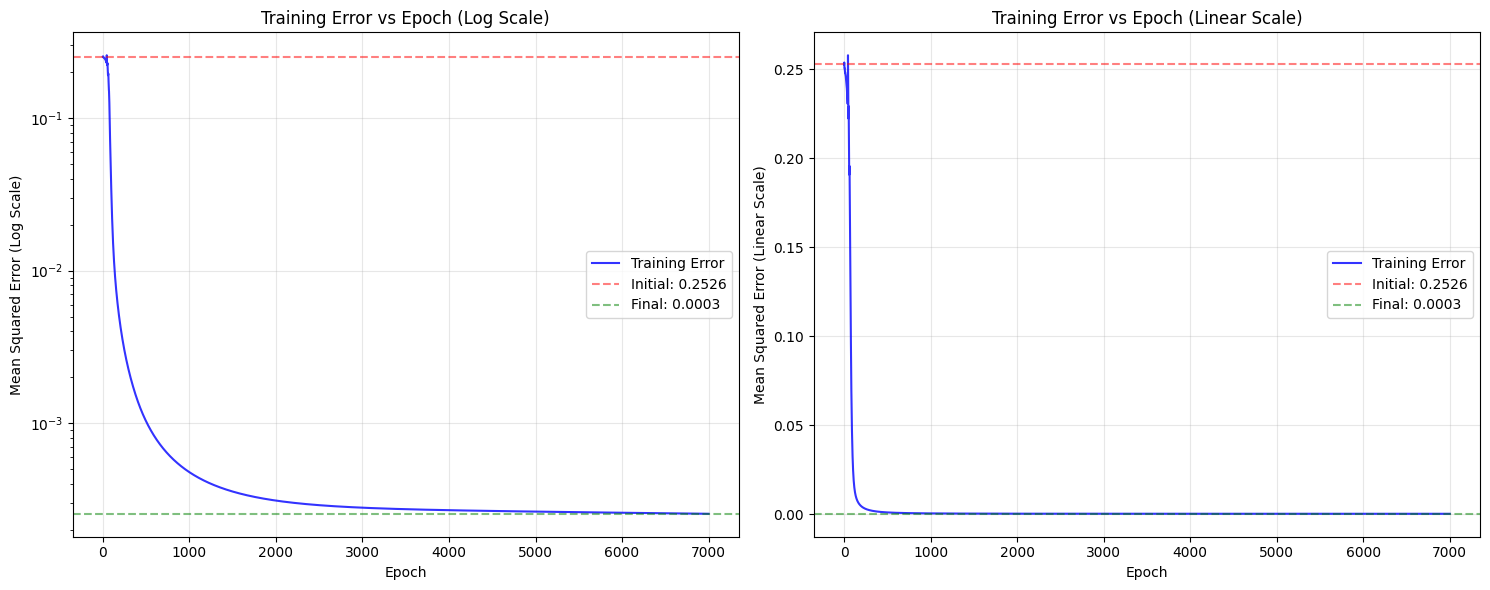

In [109]:
# ===============================================
# SIMPLIFIED VISUALIZATION OF TRAINING ERROR
# ===============================================

# Create a figure with 2 subplots side-by-side (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# -----------------------------------------------
# Plot 1: Training error over epochs (Log scale)
# -----------------------------------------------

# Plot training error in blue with some transparency and line width
ax1.plot(train_errors, 'b-', alpha=0.8, linewidth=1.5, label='Training Error')

# Label x-axis and y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error (Log Scale)')

# Title for clarity
ax1.set_title('Training Error vs Epoch (Log Scale)')

# Add grid for easier visualization
ax1.grid(True, alpha=0.3)

# Set y-axis to logarithmic scale for better convergence view
ax1.set_yscale('log')

# Add legend to identify the plotted line
ax1.legend()

# -----------------------------------------------
# Add horizontal reference lines for initial/final error
# -----------------------------------------------
initial_error = train_errors[0]
final_error = train_errors[-1]

# Dashed red line at initial error level
ax1.axhline(y=initial_error, color='red', linestyle='--', alpha=0.5, label=f'Initial: {initial_error:.4f}')

# Dashed green line at final error level
ax1.axhline(y=final_error, color='green', linestyle='--', alpha=0.5, label=f'Final: {final_error:.4f}')

# Update legend to include these reference lines
ax1.legend()

# -----------------------------------------------
# Plot 2: Training error over epochs (Linear scale)
# -----------------------------------------------

# Plot the same training error data on a linear scale
ax2.plot(train_errors, 'b-', alpha=0.8, linewidth=1.5, label='Training Error')

# Labels and title
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error (Linear Scale)')
ax2.set_title('Training Error vs Epoch (Linear Scale)')

# Add grid for readability
ax2.grid(True, alpha=0.3)

# Add legend
ax2.legend()

# Reference lines for initial and final error, matching the first plot
ax2.axhline(y=initial_error, color='red', linestyle='--', alpha=0.5, label=f'Initial: {initial_error:.4f}')
ax2.axhline(y=final_error, color='green', linestyle='--', alpha=0.5, label=f'Final: {final_error:.4f}')
ax2.legend()

# -----------------------------------------------
# Adjust layout so plots don't overlap and display
# -----------------------------------------------
plt.tight_layout()
plt.show()


# Efficiency analysis

1. Print a header indicating the start of efficiency analysis.
2. Display the total number of training epochs completed.
3. Show the initial and final training errors.
4. Calculate and print the percentage reduction in error during training.
5. Calculate the standard deviation of the error over the last 100 epochs to assess stability.
6. If the error is stable (low std), confirm training convergence; otherwise, suggest more training or tuning.

In [110]:
# ===============================================
# EFFICIENCY ANALYSIS OF TRAINING PROCESS
# ===============================================

print("\n=== EFFICIENCY ANALYSIS ===")

# Total number of epochs trained corresponds to the length of the error list
print(f"Total epochs trained: {len(train_errors)}")

# Print the initial training error (first epoch)
print(f"Initial error: {train_errors[0]:.6f}")

# Print the final training error (last epoch)
print(f"Final error: {train_errors[-1]:.6f}")

# Calculate the percentage error reduction from start to finish
error_reduction = ((train_errors[0] - train_errors[-1]) / train_errors[0]) * 100
print(f"Error reduction: {error_reduction:.2f}%")

# Check training stability by analyzing last 100 epochs' errors (or fewer if less data)
if len(train_errors) >= 100:
    final_errors = train_errors[-100:]
else:
    final_errors = train_errors

# Calculate standard deviation of the final errors to measure convergence stability
error_std = np.std(final_errors)
print(f"Final 100 epochs std: {error_std:.6f}")

# Simple heuristic: if std dev is low enough, training has converged well
if error_std < 0.001:
    print("✅ Training converged efficiently")
else:
    print("⚠️  Training may need more epochs or parameter tuning")



=== EFFICIENCY ANALYSIS ===
Total epochs trained: 7000
Initial error: 0.252561
Final error: 0.000255
Error reduction: 99.90%
Final 100 epochs std: 0.000000
✅ Training converged efficiently


# Testing and evaluation

1. Generate predictions for the test set by forwarding each test sample through the neural network.
2. Convert predictions into a NumPy array for metric calculations.
3. Compute evaluation metrics (accuracy, precision, recall, F1, MSE, confusion matrix components) on the test set.
4. Print detailed metric results for test performance.
5. Visualize the confusion matrix for the test set predictions.
6. Compare final training, validation, and test MSE values to assess model performance consistency.
7. Calculate and print ratios of validation and test errors relative to training error to check for overfitting or data leakage.
8. Provide warnings if test error suggests overfitting or data leakage; otherwise, confirm good generalization.
9. Print a final summary highlighting key training and evaluation stats including epochs, accuracies, F1-score, overfitting ratio, and model size.


=== TEST METRICS ===
Accuracy:  99.62%
Precision: 100.00%
Recall:    99.25%
F1-Score:  99.62%
MSE:       0.003133


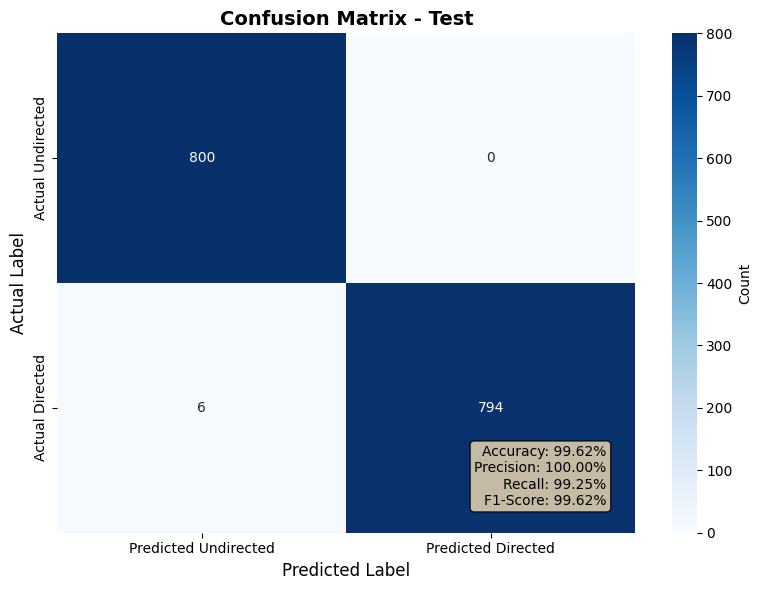


=== PERFORMANCE COMPARISON ===
Training MSE (final): 0.000255
Validation MSE: 0.002231
Test MSE: 0.003133
Validation/Training MSE ratio: 8.74
Test/Training MSE ratio: 12.27
⚠️  Test error significantly higher than training error - possible overfitting

=== FINAL SUMMARY ===
✅ Training completed in 7000 epochs (max: 7000)
✅ Validation accuracy: 99.88%
✅ Test accuracy: 99.62%
✅ Test F1-score: 99.62%
✅ Overfitting ratio: 12.27
✅ Model size: 36 hidden neurons (efficient)


In [111]:
# ===============================================
# TESTING AND EVALUATION
# ===============================================

# Predict on test data by forwarding each sample through the trained network
test_predictions = []
for i in range(len(X_test)):
    pred = nn.forward(X_test[i:i+1])[0][0]  # Forward pass, get scalar prediction
    test_predictions.append(pred)

# Convert list of predictions to numpy array for metric calculations
test_predictions = np.array(test_predictions)

# Calculate performance metrics on test dataset
test_metrics = calculate_metrics(y_test.flatten(), test_predictions)

# Print detailed metrics (accuracy, precision, recall, F1-score, MSE)
print_detailed_metrics(test_metrics, "Test")

# Visualize confusion matrix with heatmap for test predictions
plot_confusion_matrix(test_metrics, "Test")

# Print performance comparison among training, validation, and test errors
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Training MSE (final): {train_errors[-1]:.6f}")
print(f"Validation MSE: {val_errors[-1]:.6f}")
print(f"Test MSE: {test_metrics['mse']:.6f}")

# Calculate error ratios to analyze possible overfitting or data leakage
train_val_ratio = val_errors[-1] / train_errors[-1]
test_train_ratio = test_metrics['mse'] / train_errors[-1]

print(f"Validation/Training MSE ratio: {train_val_ratio:.2f}")
print(f"Test/Training MSE ratio: {test_train_ratio:.2f}")

# Basic overfitting/data leakage heuristics based on test/train error ratio
if test_train_ratio > 1.5:
    print("⚠️  Test error significantly higher than training error - possible overfitting")
elif test_train_ratio < 0.5:
    print("⚠️  Test error much lower than training error - possible data leakage")
else:
    print("✅ Good generalization - test performance is reasonable")

# Final summary of training and evaluation
print(f"\n=== FINAL SUMMARY ===")
print(f"✅ Training completed in {len(train_errors)} epochs (max: {epochs})")
print(f"✅ Validation accuracy: {val_metrics['accuracy']:.2%}")
print(f"✅ Test accuracy: {test_metrics['accuracy']:.2%}")
print(f"✅ Test F1-score: {test_metrics['f1_score']:.2%}")
print(f"✅ Overfitting ratio: {test_train_ratio:.2f}")
print(f"✅ Model size: {hidden_size} hidden neurons (efficient)")


# Comprehensive learning curve analysis

1. Define a list of hidden layer sizes that are larger than the input size to ensure the neural network can learn effectively without dimension conflicts.
2. Call a function plot_comprehensive_learning_curves to analyze and visualize training and validation errors across different hidden layer sizes.
3. Pass in existing training and validation error histories, the current neural network object, training and validation datasets, and the list of hidden sizes to explore.
4. The function likely trains multiple models with different hidden layer sizes, plots their learning curves, and returns the collected results for further inspection.

Testing capacity sizes: [36, 41, 46, 56, 86]


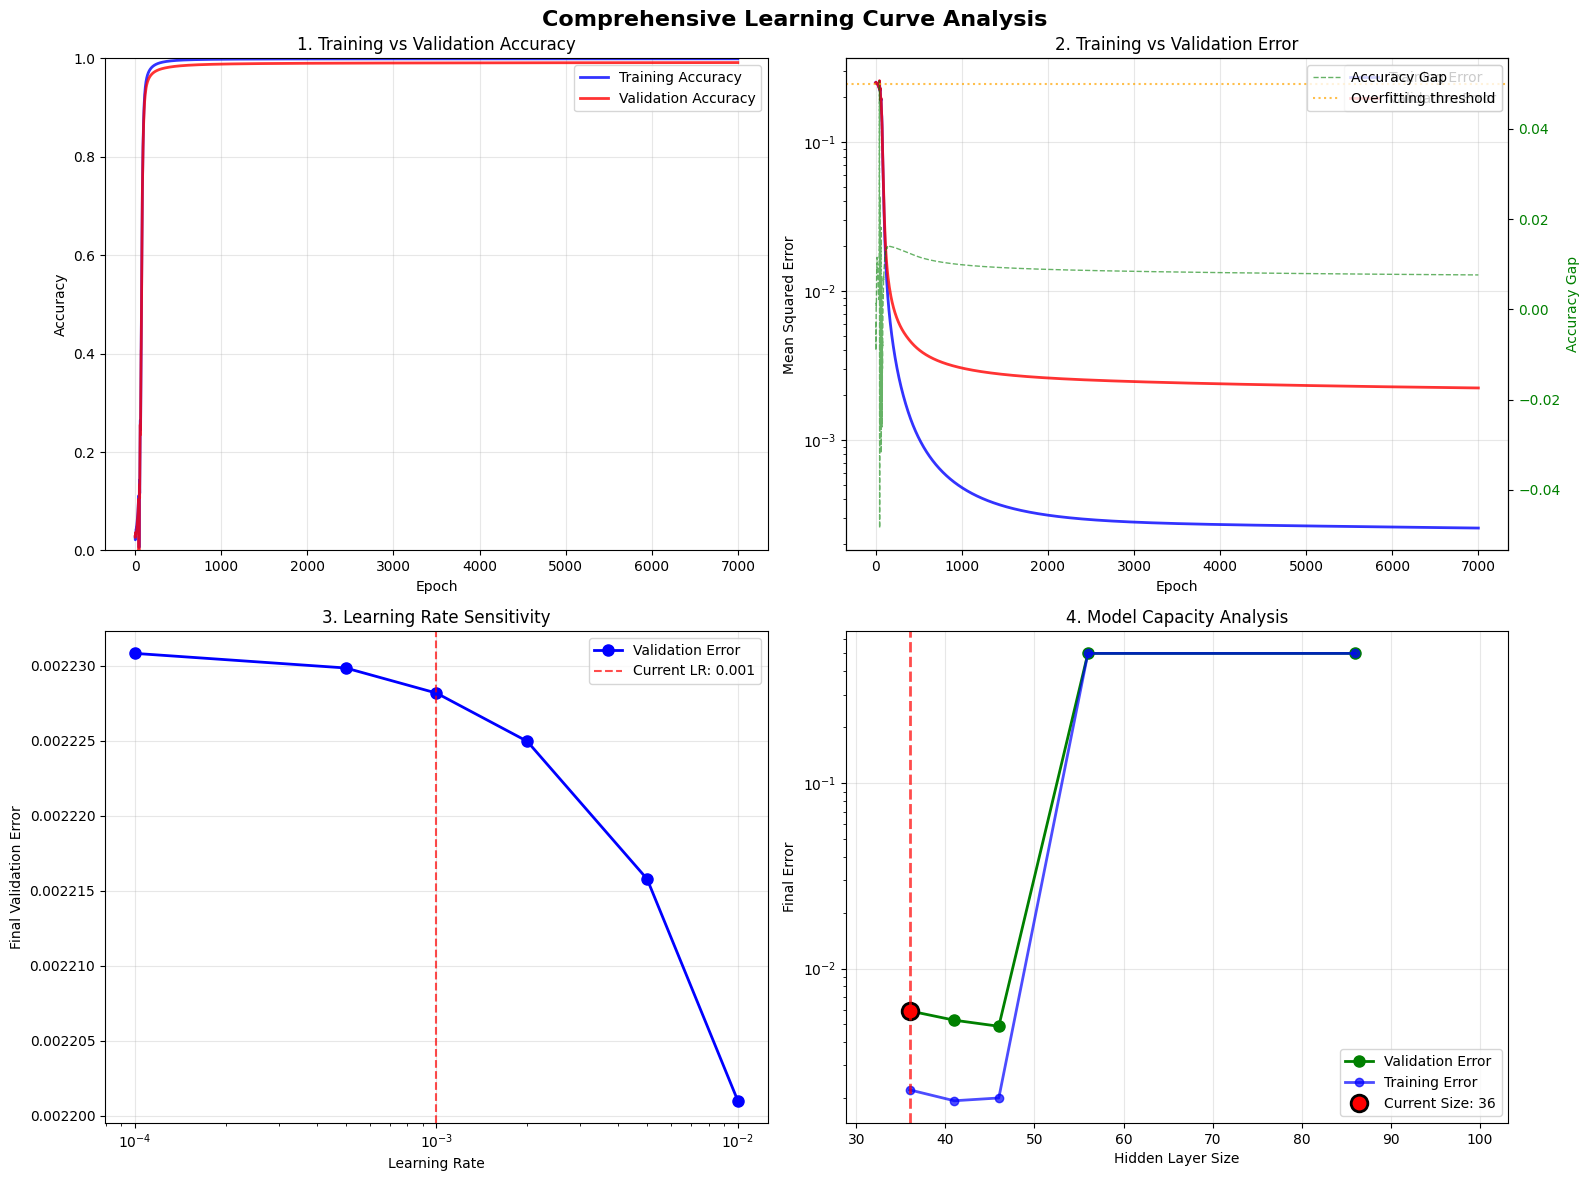


COMPREHENSIVE LEARNING CURVE ANALYSIS

1. ACCURACY ANALYSIS:
   Final Training Accuracy: 99.90%
   Final Validation Accuracy: 99.14%
   Accuracy Gap: 0.76%
   ✅ Good generalization

2. ERROR ANALYSIS:
   Final Training Error: 0.000255
   Final Validation Error: 0.002231
   Error Gap: 0.001976

3. LEARNING RATE ANALYSIS:
   Best Learning Rate: 0.01
   Current Learning Rate: 0.001
   Current LR Performance: 0.002228
   Best LR Performance: 0.002201
   ✅ Learning rate appears optimal
   (Improvement too small: 1.2%)

4. CAPACITY ANALYSIS:
   Best Hidden Size: 46
   Current Hidden Size: 36
   💡 Consider adjusting hidden layer size to 46

5. OVERALL RECOMMENDATIONS:
   1. Consider hidden layer size of 46


In [112]:
# ===============================================
# COMPREHENSIVE LEARNING CURVE ANALYSIS
# ===============================================

# Define hidden layer sizes to test.
# We choose sizes larger than input_size to avoid dimension mismatches during training.
appropriate_hidden_sizes = [
    input_size + 5,
    input_size + 10,
    input_size + 20,
    input_size + 50
]

# Run the comprehensive learning curve plotting function
# This function will:
# - Train models with each hidden layer size
# - Collect and plot training and validation errors
# - Possibly visualize and compare performance across configurations
analysis_results = plot_comprehensive_learning_curves(
    train_errors,    # Training error history from current model
    val_errors,      # Validation error history from current model
    nn,              # Current neural network instance
    X_train, y_train,  # Training data and labels
    X_val, y_val,      # Validation data and labels
    hidden_sizes=appropriate_hidden_sizes  # Different hidden sizes to evaluate
)
